In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm 
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc
import warnings

# 1. DATA LOADING AND INITIAL CLEANING

In [7]:
df = pd.read_csv('graduation_dataset.csv')

# Normalize column names to lowercase and replace spaces/special chars with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace("'", '')
print(f"Dataset loaded and columns normalized: {len(df)} rows.")
print("-" * 50)

Dataset loaded and columns normalized: 4424 rows.
--------------------------------------------------


# 2. ADVANCED DATA ENGINEERING AND PREPARATION

In [8]:
# A. Map the Target Variable (Multi-class Classification)
# We choose 0 for Graduate as the most common class.
target_mapping = {'Graduate': 0, 'Enrolled': 1, 'Dropout': 2}
df['target_encoded'] = df['target'].map(target_mapping)
y = df['target_encoded']
X = df.drop(['target', 'target_encoded'], axis=1, errors='ignore')

# B. Feature Engineering (Using normalized column names)

# 1. Success Rate 1st Semester
X['success_rate_1st_sem'] = X['curricular_units_1st_sem_approved'] / X['curricular_units_1st_sem_evaluations']

# 2. Success Rate 2nd Semester
X['success_rate_2nd_sem'] = X['curricular_units_2nd_sem_approved'] / X['curricular_units_2nd_sem_evaluations']

# Handle division by zero (inf) and NaNs created by the rates
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Imputing with 0 implies 0 success when there were 0 evaluations (often true for missing data)
X['success_rate_1st_sem'].fillna(0, inplace=True) 
X['success_rate_2nd_sem'].fillna(0, inplace=True)

# 3. Overall Success Index (Average rate)
X['overall_success_rate'] = (X['success_rate_1st_sem'] + X['success_rate_2nd_sem']) / 2

# 4. Total Units without Evaluations (Sign of disengagement/dropout)
X['total_without_evaluations'] = X['curricular_units_1st_sem_without_evaluations'] + \
                                 X['curricular_units_2nd_sem_without_evaluations']

# 5. Pending Units (Enrolled load - Approved load)
X['units_pending'] = (X['curricular_units_1st_sem_enrolled'] + X['curricular_units_2nd_sem_enrolled']) - \
                     (X['curricular_units_1st_sem_approved'] + X['curricular_units_2nd_sem_approved'])

# 6. Parents Education Index
X['parents_education_index'] = X['fathers_qualification'] + X['mothers_qualification']


C:\Users\Utente\AppData\Local\Temp\ipykernel_9820\1840635127.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['success_rate_1st_sem'].fillna(0, inplace=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_9820\1840635127.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

# 3. PREPROCESSING PIPELINE AND MODEL DEFINITION

In [9]:
# Identify columns by type (using normalized names)
categorical_features = [
    'marital_status', 'application_mode', 'application_order', 'course', 
    'daytime/evening_attendance', 'previous_qualification', 'nacionality', 
    'mothers_qualification', 'fathers_qualification', 'mothers_occupation', 
    'fathers_occupation', 'displaced', 'educational_special_needs', 
    'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 
    'international'
]

# Numeric features are all other remaining columns
numeric_features = X.columns.drop(categorical_features).tolist()


# Preprocessing Pipeline (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        # 1. One-Hot Encoding for categorical variables
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        # 2. Numerics are left "raw" (LightGBM does not require scaling)
        ('num', 'passthrough', numeric_features)
    ],
    remainder='drop'
)

# Define the LightGBM Model (LGBM)
# We REMOVE class_weight='balanced' here because we will use SMOTE for balancing.
lgbm = LGBMClassifier(
    objective='multiclass', 
    random_state=42, 
    n_jobs=-1,
)

# Creating the Full Pipeline (SMOTE + Preprocessor + Classifier)
# We use imblearn's Pipeline to integrate SMOTE only on the training folds.
full_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')), # Over-sampling minority classes
    ('classifier', lgbm)
])

# A. Split the dataset into Training and Test with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 4. SPLIT AND ADVANCED TUNING (RandomizedSearchCV)

In [10]:
# A. Split the dataset into Training and Test with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# B. Extended Hyperparameter Grid for Randomized Search
param_grid = {
    'classifier__n_estimators': [200, 400],
    'classifier__learning_rate': [0.05, 0.01],
    'classifier__max_depth': [10, 20],
    'classifier__num_leaves': [31, 63],
    'classifier__min_child_samples': [20, 50],
    'classifier__reg_lambda': [0.1, 0.5], # L2 Regularization
}

# C. Randomized Search with Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Test fewer combinations for speed, prioritizing quality over quantity (2*2*2*2*2*2 = 64, let's use all)
random_search = RandomizedSearchCV(
    full_pipeline, 
    param_grid, 
    n_iter=64, # Use all combinations, or a specific, smaller n_iter
    cv=cv, 
    scoring='f1_weighted', # Key metric for imbalanced data
    verbose=0, # Reduced verbosity for clean output
    n_jobs=-1,
    random_state=42
)

print("\n--- STARTING RANDOMIZED SEARCH AND CROSS-VALIDATION (5 FOLD) ---")
# The fit might take several minutes depending on n_iter
random_search.fit(X_train, y_train) 
print("--- RANDOMIZED SEARCH FINISHED ---")



--- STARTING RANDOMIZED SEARCH AND CROSS-VALIDATION (5 FOLD) ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15923
[LightGBM] [Info] Number of data points in the train set: 5301, number of used features: 141
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

# 5. FINAL EVALUATION AND VISUALIZATION

In [11]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

# Predictions and Probabilities
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test) # Probabilities needed for ROC AUC

# Inverse mapping for human-readable labels in reporting
reverse_target_mapping = {v: k for k, v in target_mapping.items()}
y_test_labels = y_test.map(reverse_target_mapping)
y_pred_labels = pd.Series(y_pred).map(reverse_target_mapping)

# Calculate final metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Calculate Multi-class ROC AUC (One-vs-Rest)
# Binarize the true labels for OvR analysis
y_test_bin = label_binarize(y_test, classes=np.unique(y))
try:
    ovr_roc_auc = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')
except ValueError:
    ovr_roc_auc = 'N/A (Too few samples or constant class)'


print(f"Best Hyperparameters (from Randomized Search):")
for k, v in best_params.items():
    print(f"  {k.split('__')[1]}: {v}")

print(f"\nWeighted F1-Score (Cross-Validation Avg): {best_score:.4f}")
print(f"Accuracy on Test Set: {test_accuracy:.4f}")
print(f"Weighted F1-Score on Test Set: {test_f1_weighted:.4f}")
print(f"Weighted ROC AUC Score (One-vs-Rest): {ovr_roc_auc:.4f}" if isinstance(ovr_roc_auc, float) else f"Weighted ROC AUC Score (One-vs-Rest): {ovr_roc_auc}")

print("\n--- CLASSIFICATION REPORT (Detailed Test Set Performance) ---")
print(classification_report(y_test_labels, y_pred_labels))
print("="*70)


Best Hyperparameters (from Randomized Search):
  reg_lambda: 0.1
  num_leaves: 31
  n_estimators: 400
  min_child_samples: 20
  max_depth: 10
  learning_rate: 0.01

Weighted F1-Score (Cross-Validation Avg): 0.7772
Accuracy on Test Set: 0.7751
Weighted F1-Score on Test Set: 0.7746
Weighted ROC AUC Score (One-vs-Rest): 0.9116

--- CLASSIFICATION REPORT (Detailed Test Set Performance) ---
              precision    recall  f1-score   support

     Dropout       0.86      0.75      0.80       284
    Enrolled       0.54      0.54      0.54       159
    Graduate       0.81      0.87      0.84       442

    accuracy                           0.78       885
   macro avg       0.74      0.72      0.73       885
weighted avg       0.78      0.78      0.77       885



# 6. VISUALIZATIONS 


## 1. Confusion Matrix

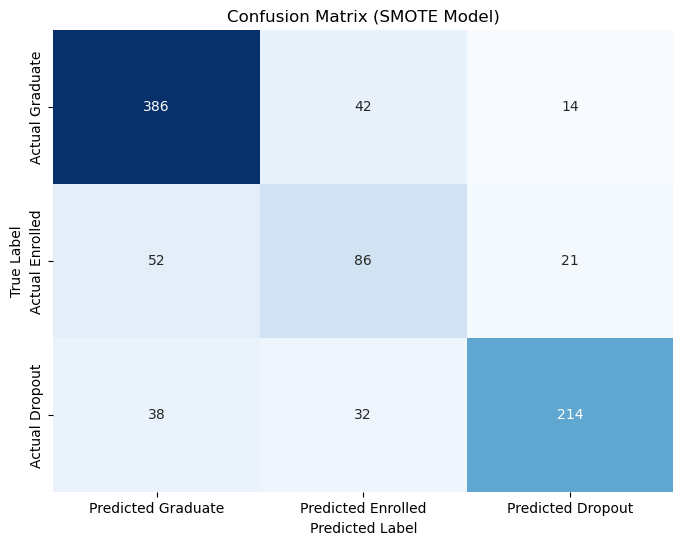

In [12]:

cm = confusion_matrix(y_test_labels, y_pred_labels, labels=['Graduate', 'Enrolled', 'Dropout'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Graduate', 'Predicted Enrolled', 'Predicted Dropout'],
            yticklabels=['Actual Graduate', 'Actual Enrolled', 'Actual Dropout'])
plt.title('Confusion Matrix (SMOTE Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 2. Feature Importance


C:\Users\Utente\AppData\Local\Temp\ipykernel_9820\3926958269.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette="viridis")


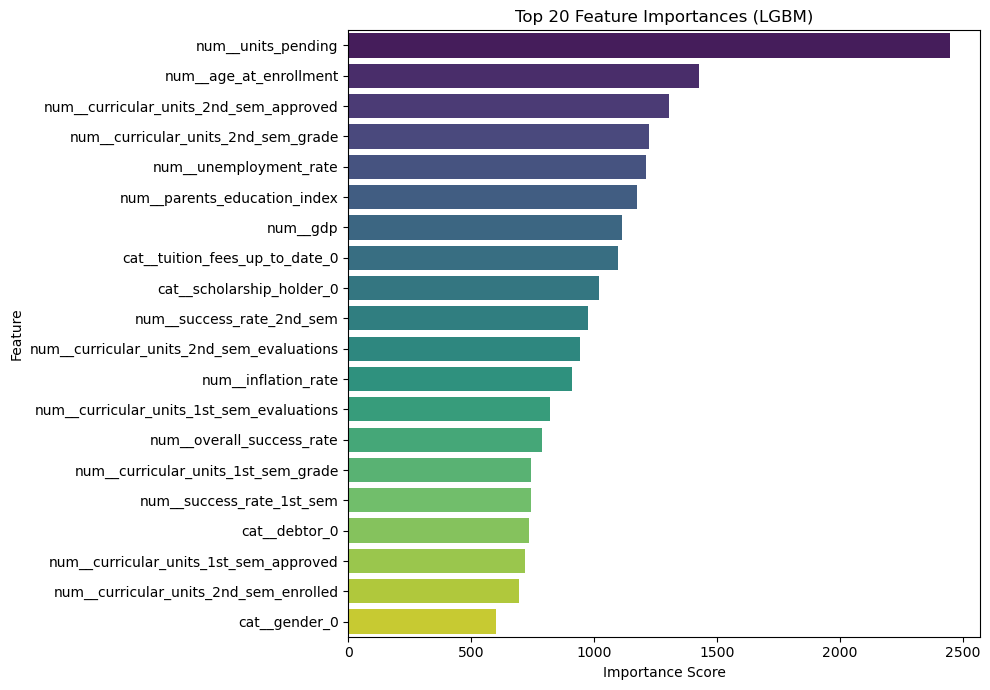

In [13]:
# Get feature names after One-Hot Encoding
feature_names = best_model['preprocessor'].get_feature_names_out()
# Get importances from the classifier
importances = best_model['classifier'].feature_importances_

# Create a Series and sort
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette="viridis")
plt.title('Top 20 Feature Importances (LGBM)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 3. SHAP Explainability


In [14]:
#explainer = shap.Explainer(final_model)
#shap_values = explainer(X_test_transformed[:500])  # subset for speed
#shap.summary_plot(shap_values, X_test_transformed[:500], feature_names=feature_names)

## 3. MULTI-CLASS ROC CURVE (NEW PLOT)

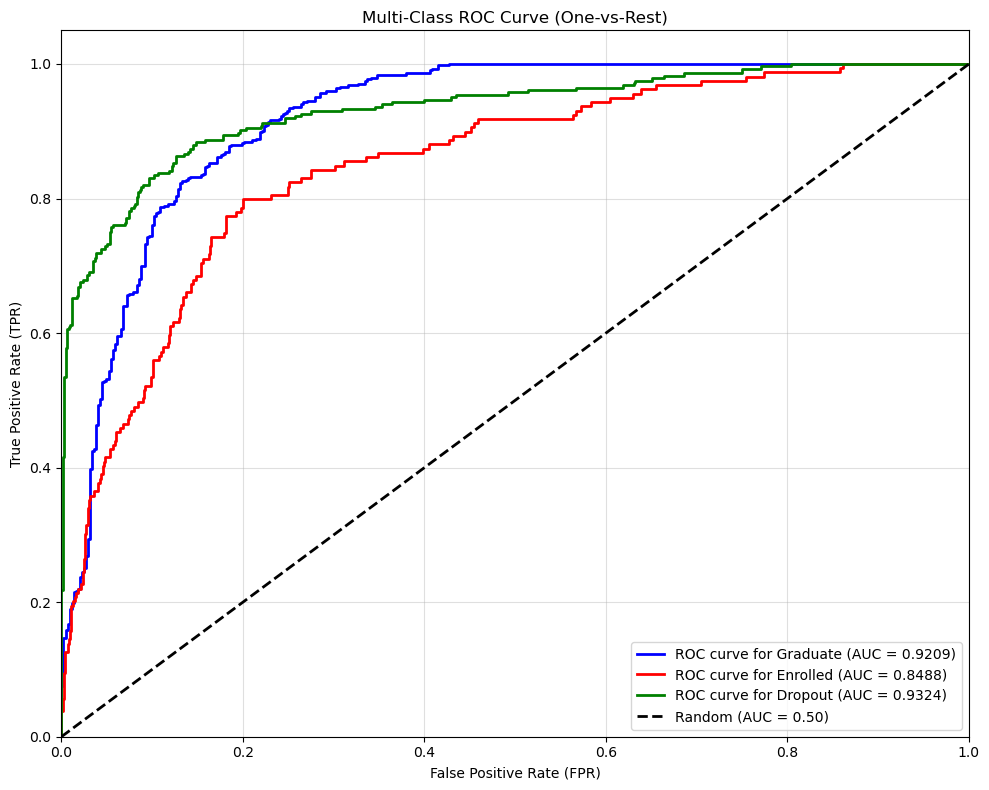

In [15]:
plt.figure(figsize=(10, 8))
classes = np.unique(y)
class_labels = list(target_mapping.keys()) # ['Graduate', 'Enrolled', 'Dropout']
colors = ['blue', 'red', 'green'] 

# Binarize y_test again for clarity
y_test_bin = label_binarize(y_test, classes=classes)

for i in range(len(classes)):
    # Calculate ROC curve for each class (One-vs-Rest)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'ROC curve for {class_labels[i]} (AUC = {roc_auc:.4f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# 7. COMPARISON WITH SIMPLE BASELINE: LOGISTIC REGRESSION

In [16]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
import time

print("\n=== BASELINE MODEL: LOGISTIC REGRESSION ===")

# Define Logistic Regression inside a similar preprocessing pipeline (no SMOTE for simplicity)
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='ovr',  # One-vs-Rest strategy for multi-class
        max_iter=1000,
        random_state=42,
        solver='lbfgs'  # Stable and efficient for small to medium data
    ))
])

# Train the baseline model
logreg_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = logreg_pipeline.predict(X_test)
y_proba_lr = logreg_pipeline.predict_proba(X_test)




=== BASELINE MODEL: LOGISTIC REGRESSION ===


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 8. Performance measures of logistic regression

In [17]:
# Metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# ROC AUC (multi-class One-vs-Rest)
try:
    roc_auc_lr = roc_auc_score(label_binarize(y_test, classes=np.unique(y)), y_proba_lr,
                               average='weighted', multi_class='ovr')
except ValueError:
    roc_auc_lr = 'N/A'

print(f"Accuracy (LogReg): {acc_lr:.4f}")
print(f"Weighted F1-Score (LogReg): {f1_lr:.4f}")

print(f"Weighted ROC AUC (LogReg): {roc_auc_lr if isinstance(roc_auc_lr, str) else f'{roc_auc_lr:.4f}'}")

print("\n--- CLASSIFICATION REPORT (Logistic Regression) ---")

# Reverse label mapping for readability
reverse_target_mapping = {0: 'Graduate', 1: 'Enrolled', 2: 'Dropout'}

print(classification_report(
    y_test.map(reverse_target_mapping),
    pd.Series(y_pred_lr).map(reverse_target_mapping)
))

Accuracy (LogReg): 0.7774
Weighted F1-Score (LogReg): 0.7628
Weighted ROC AUC (LogReg): 0.8976

--- CLASSIFICATION REPORT (Logistic Regression) ---
              precision    recall  f1-score   support

     Dropout       0.82      0.79      0.81       284
    Enrolled       0.59      0.36      0.45       159
    Graduate       0.79      0.92      0.85       442

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.76      0.78      0.76       885



# 9. Visualization for logistic regression

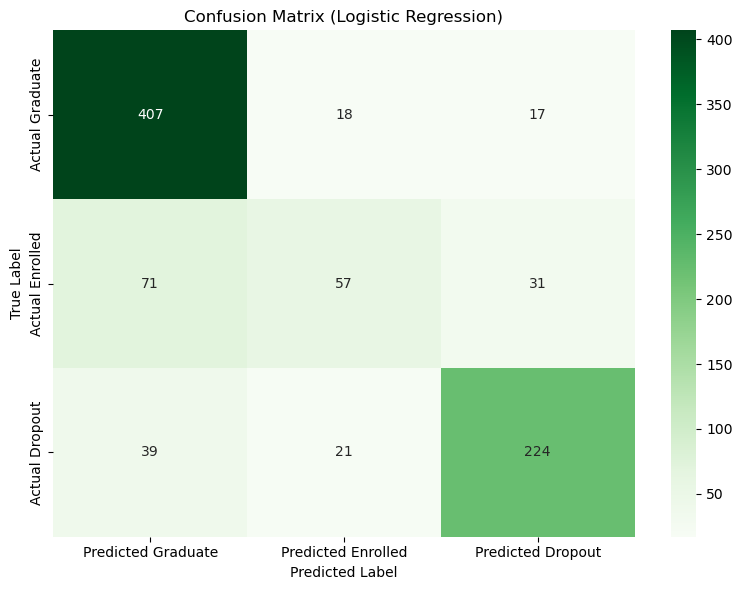


=== MODEL COMPARISON SUMMARY ===
Model                    Accuracy       Weighted F1    ROC AUC        
LightGBM (Tuned)         0.7751         0.7746         0.9116         
Logistic Regression      0.7774         0.7628         0.8976         


In [18]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Graduate', 'Predicted Enrolled', 'Predicted Dropout'],
            yticklabels=['Actual Graduate', 'Actual Enrolled', 'Actual Dropout'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print a side-by-side comparison summary
print("\n=== MODEL COMPARISON SUMMARY ===")
print(f"{'Model':<25}{'Accuracy':<15}{'Weighted F1':<15}{'ROC AUC':<15}")
print(f"{'LightGBM (Tuned)':<25}{test_accuracy:<15.4f}{test_f1_weighted:<15.4f}{(ovr_roc_auc if isinstance(ovr_roc_auc, str) else f'{ovr_roc_auc:.4f}'):<15}")
print(f"{'Logistic Regression':<25}{acc_lr:<15.4f}{f1_lr:<15.4f}{(roc_auc_lr if isinstance(roc_auc_lr, str) else f'{roc_auc_lr:.4f}'):<15}")
print("="*70)
